In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Подготовка данных от Сергея

In [2]:
data = pd.read_csv('CL_megafon_Cup IT_2020_final_data.csv', sep=';')

In [3]:
data['time_start'] = pd.to_datetime(data['time_start'])
data['time_end'] = pd.to_datetime(data['time_end'])

In [4]:
data['duration'] = data['time_end'] - data['time_start']
data['min']= data['duration'].dt.seconds/60

In [5]:
data_target = data['min'].copy()

In [6]:
low, up = np.percentile(data['min'].values, [1 , 95]) 

bad_index = list(data[data['min'].values > up].index)

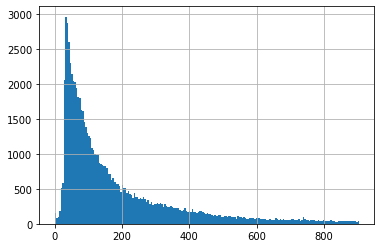

In [7]:
data['min'].drop(index=bad_index).hist(bins=200)

In [8]:
data.drop(index=bad_index, inplace=True)
data.index = range(data.shape[0])

## MeanShift

In [9]:
from sklearn.cluster import MeanShift

In [10]:
new_data = data[['place_latitude', 'place_longitude']].copy()

In [11]:
%%time

clustering = MeanShift(bandwidth = 0.1, n_jobs=-1).fit(new_data)

Wall time: 7min 32s


In [12]:
len(np.unique(clustering.predict(new_data)))

518

In [13]:
new_data['class'] = clustering.predict(new_data)

In [14]:
data['class'] = new_data['class']

In [24]:
data = data.set_index('time_start')

In [26]:
data = data.drop(columns=['time_end', 'place_latitude', 'place_longitude', 'duration'])

In [28]:
data = data.sort_index()

In [31]:
data = data.reset_index()

# Подготовительные функции

In [17]:
import tensorflow as tf

In [18]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [20]:
def make_datasets(series, batch_size=128, window_size=30):
    shuffle_buffer_size = 1000
    train_dataset = tf.data.Dataset.from_tensor_slices(series.copy())
    train_dataset = train_dataset.window(window_size + 1, shift=1, drop_remainder=True)
    train_dataset = train_dataset.flat_map(lambda window: window.batch(window_size + 1))
    train_dataset = train_dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    train_dataset = train_dataset.batch(batch_size).prefetch(1)
    return train_dataset

# Модель

In [21]:
from tensorflow.keras.layers import SimpleRNN, Lambda
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [118]:
def train_model(x_train):
    tf.keras.backend.clear_session()
    
    batch_size = min(128, len(x_train))
    window_size = min(30, len(x_train) - 1)
    
    train_dataset = make_datasets(x_train, batch_size=batch_size, window_size=window_size)
    #test_dataset = make_datasets(x_test, batch_size=128, window_size=30)

    rnn = Sequential([Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                             SimpleRNN(32, return_sequences=True),
                             SimpleRNN(16),
                             Dense(8, activation='relu'),
                             Dense(1), 
                             Lambda(lambda x : x * 500.0)])

    optimizer = tf.keras.optimizers.Adam()
    rnn.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                  optimizer=optimizer)
    return rnn, train_dataset, window_size

# Цикл моделей

In [117]:
def make_prediction(model, data_for_time_series, window_size):
    
    forecast = []
    
    for time in range(len(data_for_time_series) - window_size):
        forecast.append(model.predict(data_for_time_series[time:time + window_size].T))


    forecast = forecast[-window_size:]
    results = np.array(forecast)[:, 0]
    return list(results)

In [120]:
test_prediction = {}
s = 0
for cluster in range(0, 511 + 1):
    series = data['min'][data['class'] == cluster].copy()
    rnn, train_dataset, window = train_model(series)
    hist = rnn.fit(train_dataset, epochs=20, verbose=0)
    print('модель {} обучена, mape {}'.format(cluster, hist.history['loss'][-1]))
    test_prediction[cluster] = make_prediction(rnn, series, window)
    s += hist.history['loss'][-1]
print('Среднее mape {}'.format(s / 512))

модель 0 обучена, mape 74.8482551574707
модель 1 обучена, mape 70.47392371848777
модель 2 обучена, mape 71.24636363983154
модель 3 обучена, mape 96.4206371307373
модель 4 обучена, mape 64.32308435440063
модель 5 обучена, mape 232.71749361823586
модель 6 обучена, mape 62.72028096516927
модель 7 обучена, mape 53.69517364501953
модель 8 обучена, mape 70.64096287318638
модель 9 обучена, mape 61.95776700973511
модель 10 обучена, mape 85.28191672431097
модель 11 обучена, mape 83.39997794411399
модель 12 обучена, mape 70.14576612200055
модель 13 обучена, mape 51.13054504394531
модель 14 обучена, mape 92.18637084960938
модель 15 обучена, mape 67.86474772862026
модель 16 обучена, mape 52.03093655904134
модель 17 обучена, mape 61.49818674723307
модель 18 обучена, mape 51.19209518432617
модель 19 обучена, mape 81.17837142944336
модель 20 обучена, mape 62.08509063720703
модель 21 обучена, mape 72.31242243448894
модель 22 обучена, mape 64.31987635294597
модель 23 обучена, mape 59.531874338785805
мо

модель 193 обучена, mape 147.46524047851562
модель 194 обучена, mape 105.47450256347656
модель 195 обучена, mape 59.72380447387695
модель 196 обучена, mape 63.55485153198242
модель 197 обучена, mape 77.75220489501953
модель 198 обучена, mape 58.45656967163086
модель 199 обучена, mape 61.631385803222656
модель 200 обучена, mape 325.62908935546875
модель 201 обучена, mape 65.96688079833984
модель 202 обучена, mape 52.882362365722656
модель 203 обучена, mape 40.54810333251953
модель 204 обучена, mape 73.64530944824219
модель 205 обучена, mape 39.84339141845703
модель 206 обучена, mape 66.87448120117188
модель 207 обучена, mape 71.61910247802734
модель 208 обучена, mape 62.23152160644531
модель 209 обучена, mape 34.456993103027344
модель 210 обучена, mape 96.25688934326172
модель 211 обучена, mape 50.6323127746582
модель 212 обучена, mape 84.001220703125
модель 213 обучена, mape 67.2359619140625
модель 214 обучена, mape 51.55216598510742
модель 215 обучена, mape 72.71458435058594
модель 21

модель 383 обучена, mape 2.8267555236816406
модель 384 обучена, mape 9.24754524230957
модель 385 обучена, mape 57.97663879394531
модель 386 обучена, mape 7.1133575439453125
модель 387 обучена, mape 95.14273071289062
модель 388 обучена, mape 1.983339548110962
модель 389 обучена, mape 47.36314392089844
модель 390 обучена, mape 21.110898971557617
модель 391 обучена, mape 4.673015594482422
модель 392 обучена, mape 1.89495050907135
модель 393 обучена, mape 10.795371055603027
модель 394 обучена, mape 79.16019439697266
модель 395 обучена, mape 93.93229675292969
модель 396 обучена, mape 4.100543022155762
модель 397 обучена, mape 48.249141693115234
модель 398 обучена, mape 8.35538101196289
модель 399 обучена, mape 17.083744049072266
модель 400 обучена, mape 5.841288089752197
модель 401 обучена, mape 15.294797897338867
модель 402 обучена, mape 100.43976593017578
модель 403 обучена, mape 252.6521453857422
модель 404 обучена, mape 1.1781452894210815
модель 405 обучена, mape 5.5488386154174805
моде

In [92]:
def mape(y_true, predicted):
    return np.mean(np.abs(y_true - np.ravel(predicted)) / y_true)

In [130]:
test_prediction[512] = np.array(data['min'][data['class'] == 512])

In [131]:
test_prediction[512]

array([416.15])

# TEST PREDICTION

In [132]:
test = pd.read_csv('test.csv', sep=';')
geo = test[['place_latitude', 'place_longitude']].copy()
geo['class'] = clustering.predict(geo)
test['class'] = geo['class']

In [133]:
np.unique(test['class'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133,
       134, 135, 136, 139, 140, 141, 142, 143, 145, 146, 148, 150, 151,
       152, 153, 154, 155, 156, 159, 160, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 19

In [152]:
prediction = []
for index, row in test.iterrows():
    prediction.append(test_prediction[row['class']][0])
    if len(test_prediction[row['class']]) > 1:
        test_prediction[row['class']].pop(0)

In [153]:
prediction = np.array(prediction)

In [154]:
prediction = [abs(float(i)) for i in prediction]

In [157]:
test = test.drop(columns=['class'])

In [158]:
test['predicted_duration_mins'] = prediction

In [160]:
test.to_csv('prediction.csv')